In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import tensorflow_io as tfio

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

## Loading data from directory

In [3]:
data = pathlib.Path('Data');data

PosixPath('Data')

In [4]:
classes = np.array(tf.io.gfile.listdir(data))

In [5]:
# classes = os.listdir(data)

In [6]:
classes

array(['Human', 'Noise'], dtype='<U5')

In [7]:
filenames = tf.io.gfile.glob(str(data) + '/*/*')

In [8]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

In [9]:
print(f'Total Samples: {num_samples}\nData of {data/classes[0]}:{len(tf.io.gfile.listdir(str(data/classes[0])))}\nFilename:{filenames[0]}')

Total Samples: 2414
Data of Data/Human:1233
Filename:b'Data/Noise/noise_2206211625019435.wav'


## Splitting Data into training, validation and testing

In [10]:
# train_size, val_size, test_size = math.ceil(num_samples*tr_p), math.ceil(num_samples*v_p), math.ceil(num_samples*te_p)
train_files = filenames[:int(0.8*len(filenames))]
val_files = filenames[int(0.8*len(filenames)):int(0.9*len(filenames))]
test_files = filenames[int(0.9*len(filenames)):]

In [11]:
print(sum([len(train_files), len(val_files) , len(test_files)]))
len(train_files), len(val_files), len(test_files)
# sum([535, 178, 178])

2414


(1931, 241, 242)

## Preprocessing Audio data

In [12]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [14]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

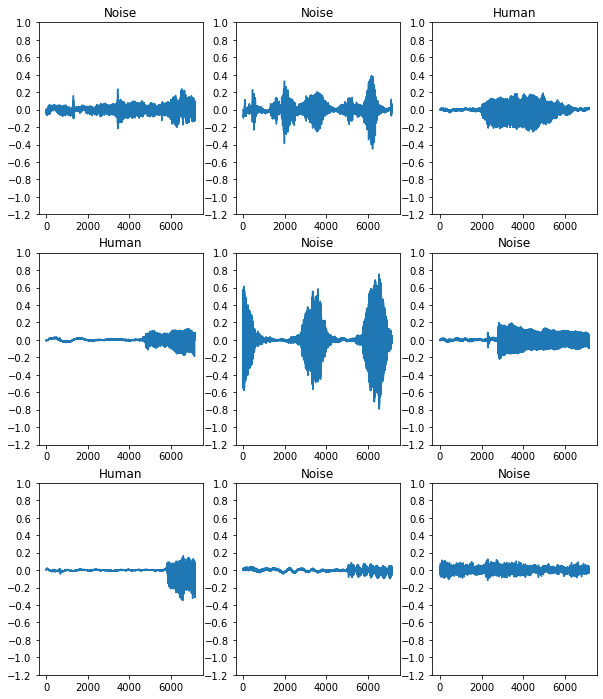

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

In [17]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
#     waveform = tfio.audio.fade(waveform, fade_in=1000, fade_out=2000, mode="logarithmic")
    zero_padding = tf.zeros([8000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32) / 32768.0
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [18]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=8000))

Label: Noise
Waveform shape: (7168,)
Spectrogram shape: (122, 129)
Audio playback


<ipython-input-19-8fea2bc013b7>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


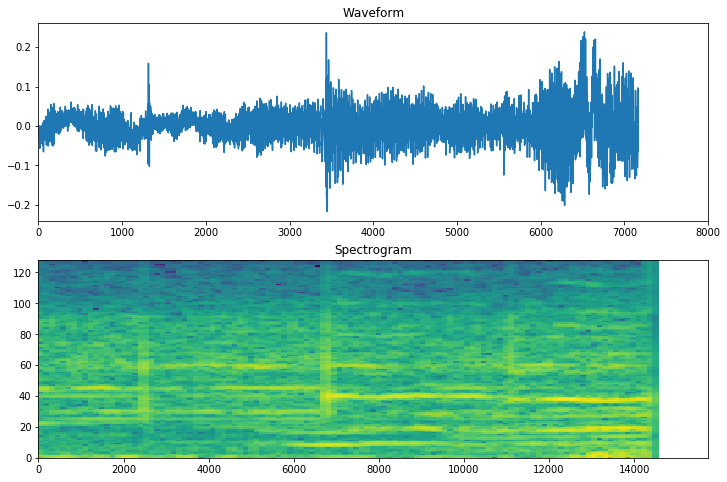

In [19]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [20]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == classes)
    return spectrogram, label_id

In [21]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-19-8fea2bc013b7>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


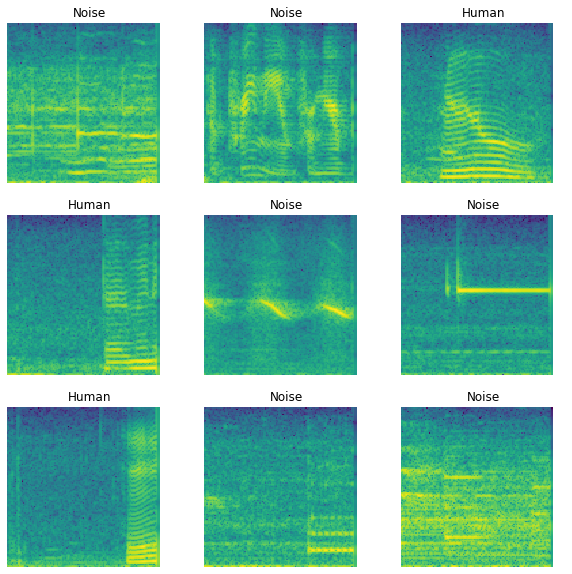

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(classes[label_id.numpy()])
    ax.axis('off')

plt.show()

## Process dataset

In [23]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [24]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [25]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [26]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [27]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('Input shape:', input_shape)
    num_labels = len(classes)

Input shape: (122, 129, 1)


In [28]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

## Creating Model

In [29]:
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
#     layers.Dropout(0.5),
    layers.Dense(num_labels),
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Training Model

In [32]:
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
61/61 [==============================] - 6s 80ms/step - loss: 0.5772 - accuracy: 0.8431 - val_loss: 0.5133 - val_accuracy: 0.9170
Epoch 2/30
61/61 [==============================] - 2s 32ms/step - loss: 0.4889 - accuracy: 0.9208 - val_loss: 0.4442 - val_accuracy: 0.9627
Epoch 3/30
61/61 [==============================] - 2s 33ms/step - loss: 0.4385 - accuracy: 0.9425 - val_loss: 0.4028 - val_accuracy: 0.9627
Epoch 4/30
61/61 [==============================] - 2s 32ms/step - loss: 0.3887 - accuracy: 0.9627 - val_loss: 0.3733 - val_accuracy: 0.9627
Epoch 5/30
61/61 [==============================] - 2s 31ms/step - loss: 0.3537 - accuracy: 0.9684 - val_loss: 0.3450 - val_accuracy: 0.9627
Epoch 6/30
61/61 [==============================] - 2s 31ms/step - loss: 0.3288 - accuracy: 0.9689 - val_loss: 0.3156 - val_accuracy: 0.9710
Epoch 7/30
61/61 [==============================] - 2s 31ms/step - loss: 0.3018 - accuracy: 0.9715 - val_loss: 0.3060 - val_accuracy: 0.9585
Epoch 8/30
61

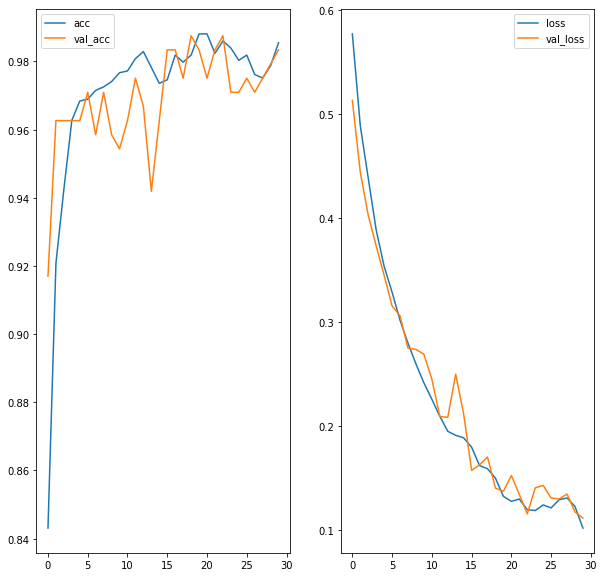

In [33]:
metrics = history.history
t_acc, v_acc = metrics['accuracy'], metrics['val_accuracy']
t_loss, v_loss = metrics['loss'], metrics['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.epoch, t_acc, label='acc')
plt.plot(history.epoch, v_acc, label='val_acc')

plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(history.epoch, t_loss,label='Training')
plt.plot(history.epoch, v_loss,label='Validation')
plt.legend(['loss', 'val_loss'])
plt.show()

In [34]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [35]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 98%


## Confusion Matrix

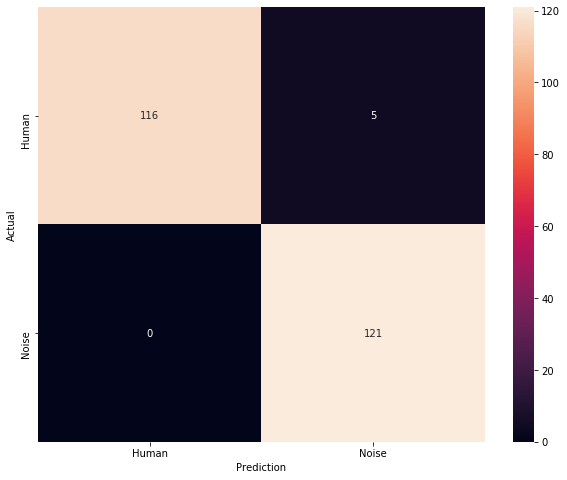

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## Testing Model 

In [55]:
# models.save_model(model,'Best_Model_human')

In [56]:
# model = models.load_model('Model')

(1, 122, 129, 1)
Noise


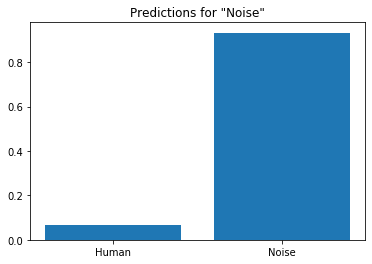

In [40]:
sample_file = data/'Noise/noise_1.wav'
sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
    print(spectrogram.shape)
    prediction = model(spectrogram)
    print(classes[np.argmax(prediction)])
    plt.bar(classes, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{classes[label[0]]}"')
    plt.show()

In [41]:
from datetime import datetime
import time
import pyaudio
import wave

class Record:

    def __init__(self, label):
        self.chunk = 1024
        self.sample_format = pyaudio.paInt16
        self.channels = 1
        self.fs = 8000
        self.seconds = 1
        self.label = label

    def recording(self):
        frames = list()
        filename = f"{self.label}_{rec.random_id()}.wav"
        p = pyaudio.PyAudio()
        print('Recording')
        stream = p.open(format=self.sample_format,channels=self.channels,rate=self.fs,frames_per_buffer=self.chunk,input=True)
        for i in range(0, int(self.fs / self.chunk * self.seconds)):
            data = stream.read(self.chunk)
            frames.append(data)

        stream.stop_stream()
        stream.close()
        p.terminate()
        print('Finished recording')

        wf = wave.open(filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(p.get_sample_size(self.sample_format))
        wf.setframerate(self.fs)
        wf.writeframes(b''.join(frames))
        wf.close()
        print(filename)
        return filename
    
    def random_id(self):
        dt = datetime.utcnow()
        stamp = time.mktime(dt.timetuple()) + dt.microsecond / 1e0
        today = time.strftime("%d%m%y")
        stamp_id = str(today) + str(stamp).split(".")[0]
        return stamp_id

In [42]:
rec=Record('sample')
os.getcwd()

'/home/mike/Documents/MIKE/DeepLearning/Audio'

In [43]:
# sample_file = rec.recording()

In [44]:
# print(sample_file)

Recording
Finished recording
sample_0107211626080087.wav
(122, 129, 1)
Human


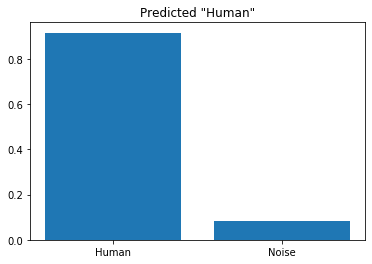

In [47]:
# print(sample_file)
# sample_file = 'Data/Human/output_e0a7c5a0_nohash_0.wav'
# sample_file = 'Sample_3006211625443149.wav'
# sample_file = rec.recording()
audio_binary = tf.io.read_file(sample_file)
audio, _ = tf.audio.decode_wav(audio_binary)
_audio = tf.squeeze(audio, axis=-1)
_spectrogram = get_spectrogram(_audio)
spectrogram = tf.expand_dims(_spectrogram, -1)
# spectrogram = tf.expand_dims(spectrogram, 0)
# np.argmax(model.predict(spectrogram), axis=1)
print(spectrogram.shape)
pred = model(spectrogram)
cls = np.argmax(tf.nn.softmax(pred[0]))
output = 'Human' if cls==0 else 'Noise'
print(output)
plt.bar(classes, tf.nn.softmax(pred[0]))
plt.title(f'Predicted "{output}"')
plt.show()
# print(tf.nn.softmax(pred[0]))
# if tf.nn.softmax(pred[0])[0]>0.50:
#     print('Noise')
# elif tf.nn.softmax(pred[0])[1]>0.50:
#     print('Human')

# sample_ds = preprocess_dataset([str(sample_file)])
# for i , j in sample_ds.batch(1):
#     print(i.shape)

In [48]:
# rec.predict()

## Cleaning data

In [49]:
# !ls

In [50]:
# data = [file for file in os.listdir('Data/Human')]
# len(data), type(data), data[0]

In [51]:
# import noisereduce as nr
# import librosa
# from scipy.io import wavfile
# # load data
# # rate, data = wavfile.read("sample_2806211624974063.wav")
# # select section of data that is noise
# data, sampling_rate = librosa.load('sample_2906211625834785.wav')
# noisy_part = data[8000:14000]
# # perform noise reduction

In [52]:
# data, sampling_rate = librosa.load('sample_2906211625113841.wav')
# reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=False)
# print(type(reduced_noise))
# wavfile.write('noise_reduce.wav', 8000, reduced_noise)
# # trimmed, index = librosa.effects.trim(reduced_noise, top_db=20, frame_length=512, hop_length=64)
# # wavfile.write('trimmed.wav', 8000, trimmed)
# # print(type(trimmed))